# Classification

Table of Contents
1. [Classifier comparison](#Classifier-comparison)
2. [Plot classification probability](#Plot-classification-probability)
3. [Recognizing hand-written digits](#Recognizing-hand-written-digits)

<a name='Classifier-comparison'></a>
## Classifier comparison

A comparison of several classifiers in scikit-learn on synthetic datasets. The point of this example is to illustrate the nature of decision boundaries of different classifiers. This should be taken with a grain of salt, as the intuition conveyed by these examples does not necessarily carry over to real datasets.

Particularly in high-dimensional spaces, data can more easily be separated linearly and the simplicity of classifiers such as naive Bayes and linear SVMs might lead to better generalization than is achieved by other classifiers.

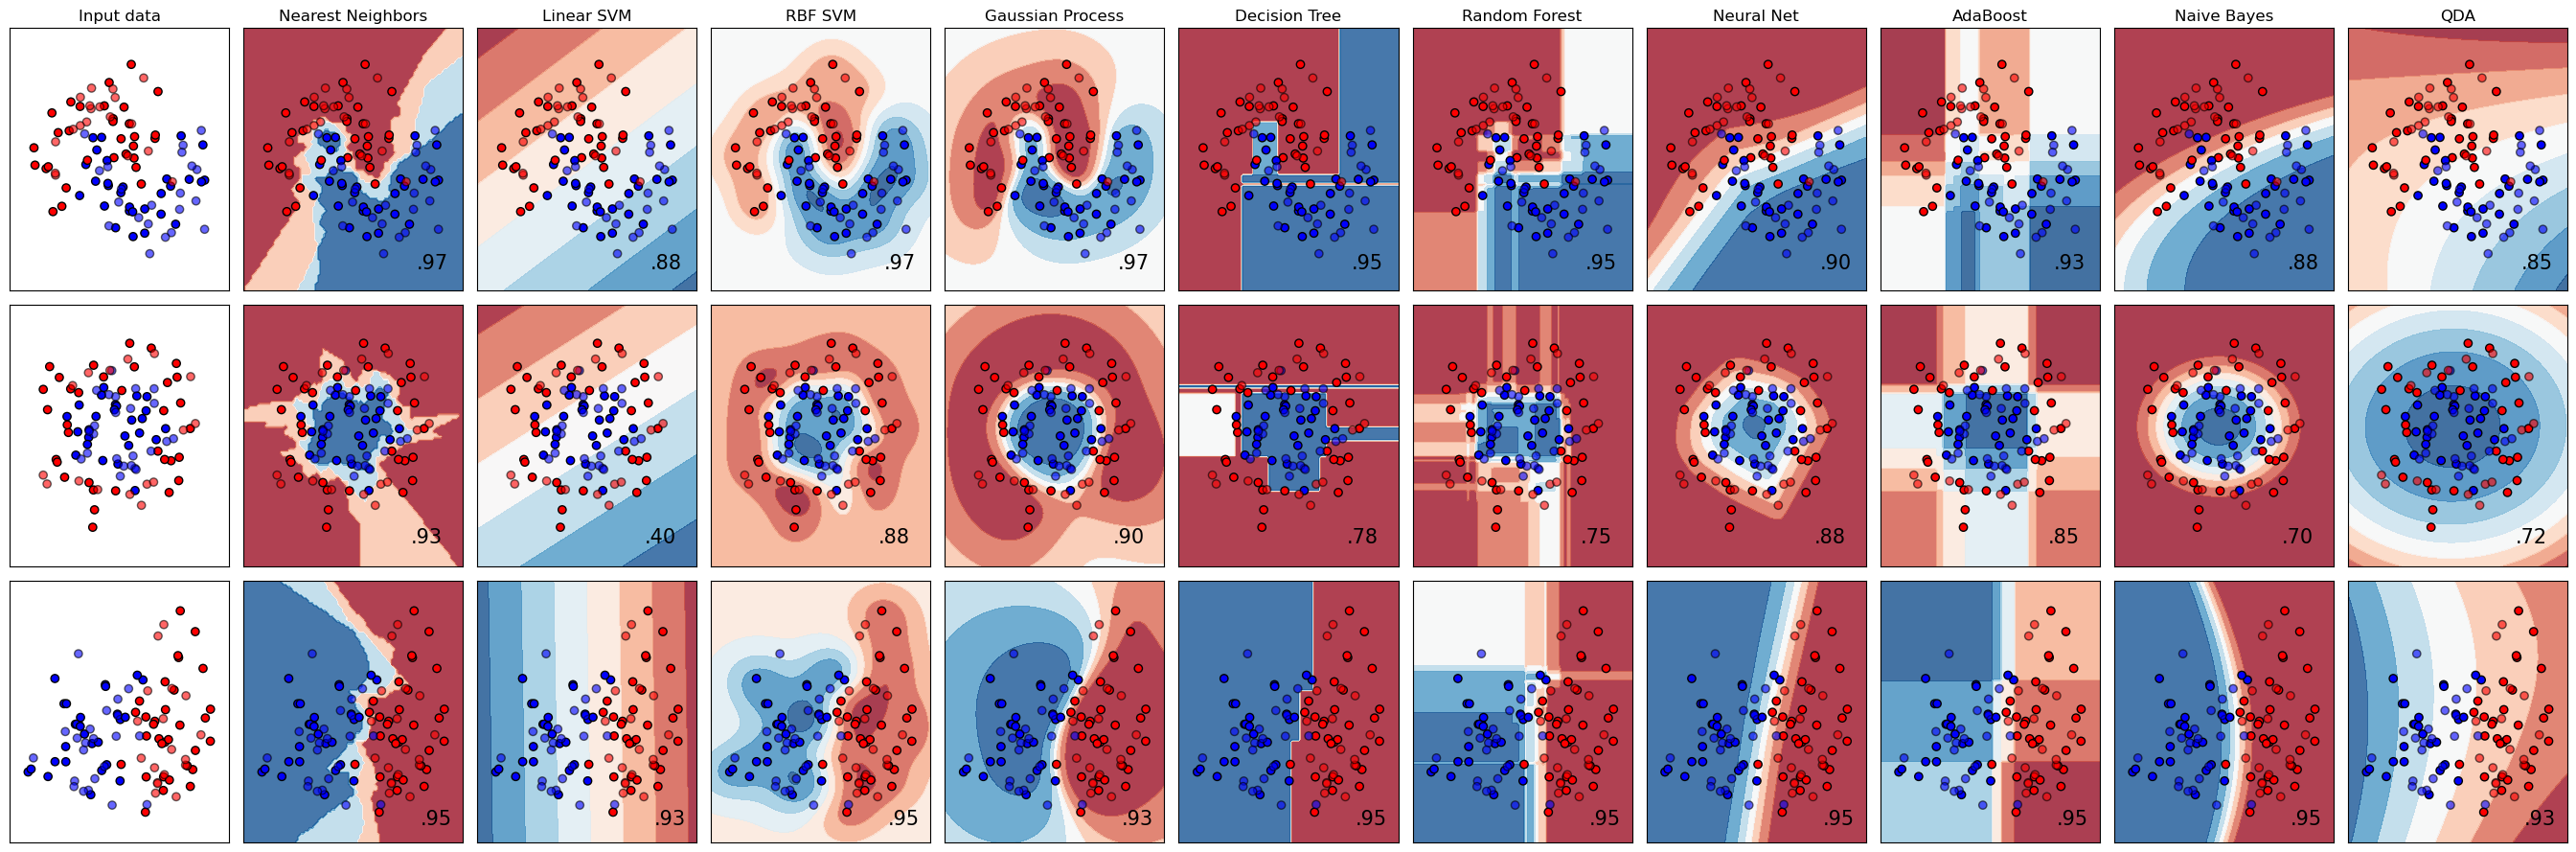

In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

The plots show training points in solid colors and testing points semi-transparent. The lower right shows the classification accuracy on the test set.

<a name='Plot-classification-probability'></a>
## Plot classification probability

This example illustrates the use of sklearn.inspection.DecisionBoundaryDisplay to plot the predicted class probabilities of various classifiers in a 2D feature space, mostly for didactic purposes.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

from sklearn import datasets
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    KBinsDiscretizer,
    PolynomialFeatures,
    SplineTransformer,
)

In [2]:
# Data: 2D projection of the iris dataset
iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42
)

In [3]:
# Probabilistic classifiers
classifiers = {
    "Logistic regression\n(C=0.01)": LogisticRegression(C=0.1),
    "Logistic regression\n(C=1)": LogisticRegression(C=100),
    "Gaussian Process": GaussianProcessClassifier(kernel=1.0 * RBF([1.0, 1.0])),
    "Logistic regression\n(RBF features)": make_pipeline(
        Nystroem(kernel="rbf", gamma=5e-1, n_components=50, random_state=1),
        LogisticRegression(C=10),
    ),
    "Gradient Boosting": HistGradientBoostingClassifier(),
    "Logistic regression\n(binned features)": make_pipeline(
        KBinsDiscretizer(n_bins=5, quantile_method="averaged_inverted_cdf"),
        PolynomialFeatures(interaction_only=True),
        LogisticRegression(C=10),
    ),
    "Logistic regression\n(spline features)": make_pipeline(
        SplineTransformer(n_knots=5),
        PolynomialFeatures(interaction_only=True),
        LogisticRegression(C=10),
    ),
}

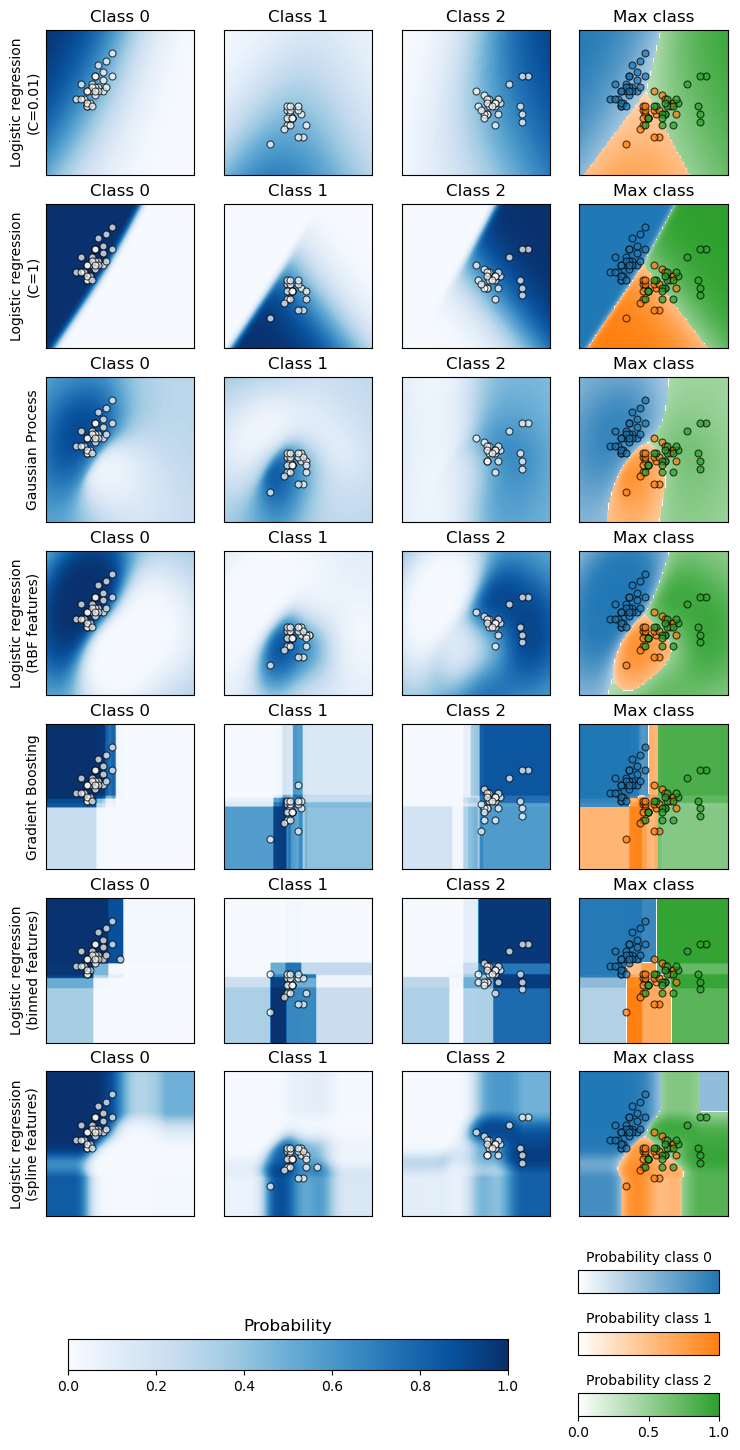

In [4]:
# Plotting the decision boundaries
n_classifiers = len(classifiers)
scatter_kwargs = {
    "s": 25,
    "marker": "o",
    "linewidths": 0.8,
    "edgecolor": "k",
    "alpha": 0.7,
}
y_unique = np.unique(y)

# Ensure legend not cut off
mpl.rcParams["savefig.bbox"] = "tight"
fig, axes = plt.subplots(
    nrows=n_classifiers,
    ncols=len(iris.target_names) + 1,
    figsize=(4 * 2.2, n_classifiers * 2.2),
)
evaluation_results = []
levels = 100
for classifier_idx, (name, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)
    accuracy_test = accuracy_score(y_test, y_pred)
    roc_auc_test = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
    log_loss_test = log_loss(y_test, y_pred_proba)
    evaluation_results.append(
        {
            "name": name.replace("\n", " "),
            "accuracy": accuracy_test,
            "roc_auc": roc_auc_test,
            "log_loss": log_loss_test,
        }
    )
    for label in y_unique:
        # plot the probability estimate provided by the classifier
        disp = DecisionBoundaryDisplay.from_estimator(
            classifier,
            X_train,
            response_method="predict_proba",
            class_of_interest=label,
            ax=axes[classifier_idx, label],
            vmin=0,
            vmax=1,
            cmap="Blues",
            levels=levels,
        )
        axes[classifier_idx, label].set_title(f"Class {label}")
        # plot data predicted to belong to given class
        mask_y_pred = y_pred == label
        axes[classifier_idx, label].scatter(
            X_test[mask_y_pred, 0], X_test[mask_y_pred, 1], c="w", **scatter_kwargs
        )

        axes[classifier_idx, label].set(xticks=(), yticks=())
    # add column that shows all classes by plotting class with max 'predict_proba'
    max_class_disp = DecisionBoundaryDisplay.from_estimator(
        classifier,
        X_train,
        response_method="predict_proba",
        class_of_interest=None,
        ax=axes[classifier_idx, len(y_unique)],
        vmin=0,
        vmax=1,
        levels=levels,
    )
    for label in y_unique:
        mask_label = y_test == label
        axes[classifier_idx, 3].scatter(
            X_test[mask_label, 0],
            X_test[mask_label, 1],
            c=max_class_disp.multiclass_colors_[[label], :],
            **scatter_kwargs,
        )

    axes[classifier_idx, 3].set(xticks=(), yticks=())
    axes[classifier_idx, 3].set_title("Max class")
    axes[classifier_idx, 0].set_ylabel(name)

# colorbar for single class plots
ax_single = fig.add_axes([0.15, 0.01, 0.5, 0.02])
plt.title("Probability")
_ = plt.colorbar(
    cm.ScalarMappable(norm=None, cmap=disp.surface_.cmap),
    cax=ax_single,
    orientation="horizontal",
)

# colorbars for max probability class column
max_class_cmaps = [s.cmap for s in max_class_disp.surface_]

for label in y_unique:
    ax_max = fig.add_axes([0.73, (0.06 - (label * 0.04)), 0.16, 0.015])
    plt.title(f"Probability class {label}", fontsize=10)
    _ = plt.colorbar(
        cm.ScalarMappable(norm=None, cmap=max_class_cmaps[label]),
        cax=ax_max,
        orientation="horizontal",
    )
    if label in (0, 1):
        ax_max.set(xticks=(), yticks=())

The first three columns shows the predicted probability for varying values of the two features. Round markers represent the test data that was predicted to belong to that class.

In the last column, all three classes are represented on each plot; the class with the highest predicted probability at each point is plotted. The round markers show the test data and are colored by their true label.

In [5]:
# Quantitative evaluation
pd.DataFrame(evaluation_results).round(2)

,name,accuracy,roc_auc,log_loss
0,Logistic regression (C=0.01),0.83,0.92,0.71
1,Logistic regression (C=1),0.81,0.93,0.36
2,Gaussian Process,0.80,0.93,0.54
3,Logistic regression (RBF features),0.77,0.93,0.40
4,Gradient Boosting,0.83,0.92,0.40
5,Logistic regression (binned features),0.81,0.92,0.48
6,Logistic regression (spline features),0.79,0.92,0.42


### Analysis

The two logistic regression models fitted on the original features display linear decision boundaries as expected. For this particular problem, this does not seem to be detrimental as both models are competitive with the non-linear models when quantitatively evaluated on the test set. We can observe that the amount of regularization influences the model confidence: lighter colors for the strongly regularized model with a lower value of C. Regularization also impacts the orientation of decision boundary leading to slightly different ROC AUC.

The log-loss on the other hand evaluates both sharpness and calibration and as a result strongly favors the weakly regularized logistic-regression model, probably because the strongly regularized model is under-confident. This could be confirmed by looking at the calibration curve using sklearn.calibration.CalibrationDisplay.

The logistic regression model with RBF features has a “blobby” decision boundary that is non-linear in the original feature space and is quite similar to the decision boundary of the Gaussian process classifier which is configured to use an RBF kernel.

The logistic regression model fitted on binned features with interactions has a decision boundary that is non-linear in the original feature space and is quite similar to the decision boundary of the gradient boosting classifier: both models favor axis-aligned decisions when extrapolating to unseen region of the feature space.

The logistic regression model fitted on spline features with interactions has a similar axis-aligned extrapolation behavior but a smoother decision boundary in the dense region of the feature space than the two previous models.

To conclude, it is interesting to observe that feature engineering for logistic regression models can be used to mimic some of the inductive bias of various non-linear models. However, for this particular dataset, using the raw features is enough to train a competitive model. This would not necessarily the case for other datasets.

<a name='Recognizing-hand-written-digits'></a>
# Recognizing hand-written digits

This example shows how scikit-learn can be used to recognize images of hand-written digits, from 0-9.

The digits dataset consists of 8x8 pixel images of digits. The images attribute of the dataset stores 8x8 arrays of grayscale values for each image. We will use these arrays to visualize the first 4 images. The target attribute of the dataset stores the digit each image represents and this is included in the title of the 4 plots below.

Note: if we were working from image files (e.g., ‘png’ files), we would load them using matplotlib.pyplot.imread.

In [6]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split

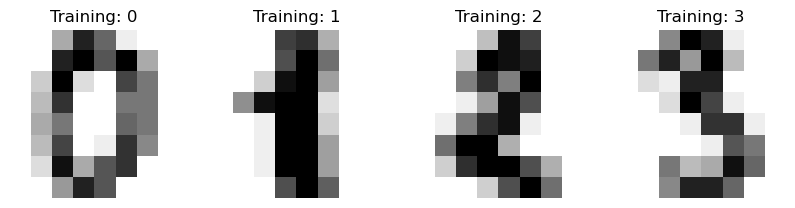

In [7]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [12]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)

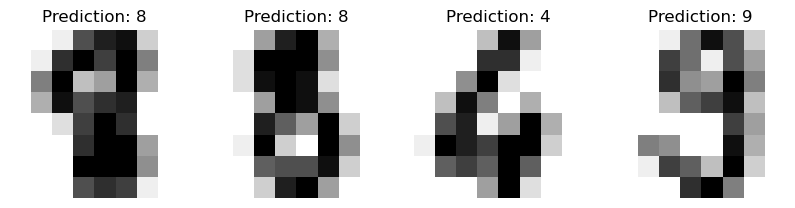

In [13]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

In [14]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)

Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899




Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


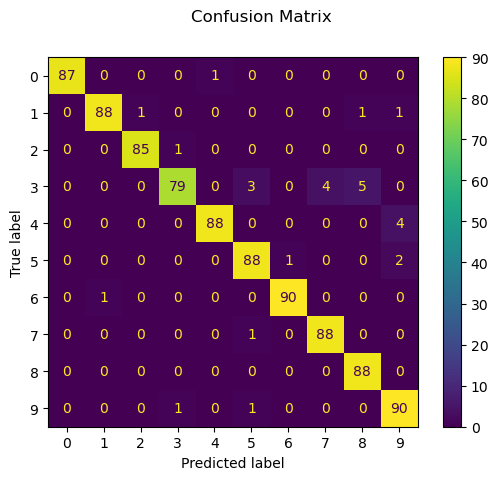

In [15]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()

In [16]:
# The ground truth and predicted lists
y_true = []
y_pred = []
cm = disp.confusion_matrix

# For each cell in the confusion matrix, add the corresponding ground truths
# and predictions to the lists
for gt in range(len(cm)):
    for pred in range(len(cm)):
        y_true += [gt] * cm[gt][pred]
        y_pred += [pred] * cm[gt][pred]

print(
    "Classification report rebuilt from confusion matrix:\n"
    f"{metrics.classification_report(y_true, y_pred)}\n"
)

Classification report rebuilt from confusion matrix:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      0.97      0.98        91
           2       0.99      0.99      0.99        86
           3       0.98      0.87      0.92        91
           4       0.99      0.96      0.97        92
           5       0.95      0.97      0.96        91
           6       0.99      0.99      0.99        91
           7       0.96      0.99      0.97        89
           8       0.94      1.00      0.97        88
           9       0.93      0.98      0.95        92

    accuracy                           0.97       899
   macro avg       0.97      0.97      0.97       899
weighted avg       0.97      0.97      0.97       899


